In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
metadata = pd.read_csv("../HAM10000_metadata.csv")
metadata.describe(include="all")

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0032393,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [5]:
print(metadata.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [6]:
labels = list(metadata.dx.unique())
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


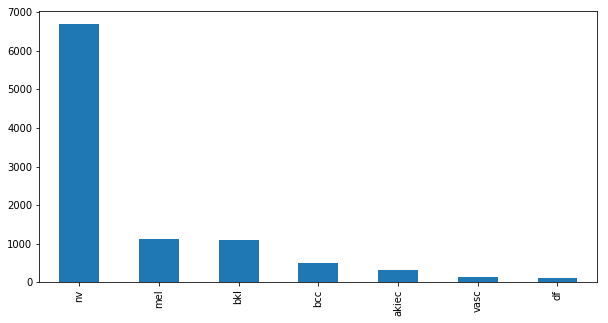

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
counts = metadata["dx"].value_counts()
print(counts)
counts.plot(kind='bar', ax=ax1)
#metadata["dx"].hist()

In [22]:
# parse out all classes to individual dataframes
nv = metadata[metadata["dx"] == "nv"]
nv.name = "nv"
mel = metadata[metadata["dx"] == "mel"]
mel.name = "mel"
bkl = metadata[metadata["dx"] == "bkl"]
bkl.name = "bkl"
bcc = metadata[metadata["dx"] == "bcc"]
bcc.name = "bcc"
akiec = metadata[metadata["dx"] == "akiec"]
akiec.name = "akiec"
vasc = metadata[metadata["dx"] == "vasc"]
vasc.name = "vasc"
df = metadata[metadata["dx"] == "df"]
df.name = "df"
# list out
classes = [nv, mel, bkl, bcc, akiec, vasc, df]

In [9]:
# preprocess accordingly
def preprocess(_image):
    #_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)
    
    _image = cv2.equalizeHist(_image) 
    #_image = cv2.GaussianBlur(_image, (3,3), 1)
    #_image = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
    #H,S,V = cv2.split(_image)
    #_V = cv2.equalizeHist(V) 
    #_image = cv2.merge([H, S, _V])
    #_image = cv2.cvtColor(_image, cv2.COLOR_HSV2RGB)
    
    return _image

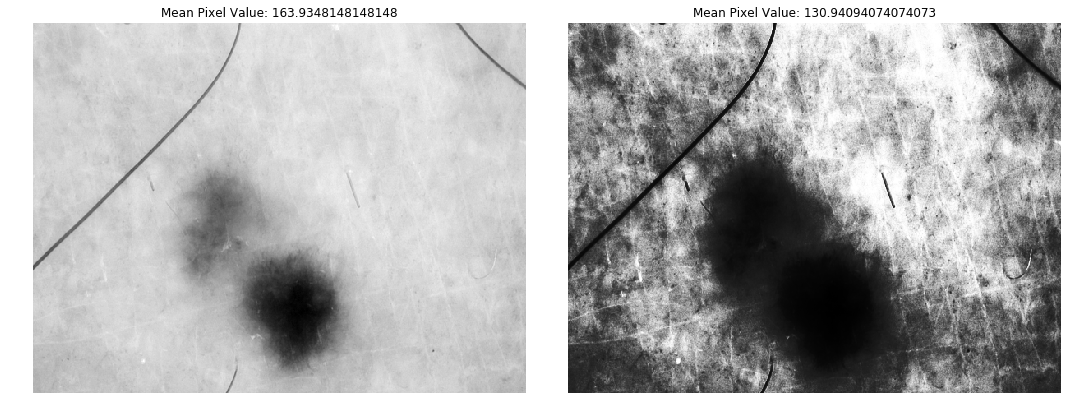

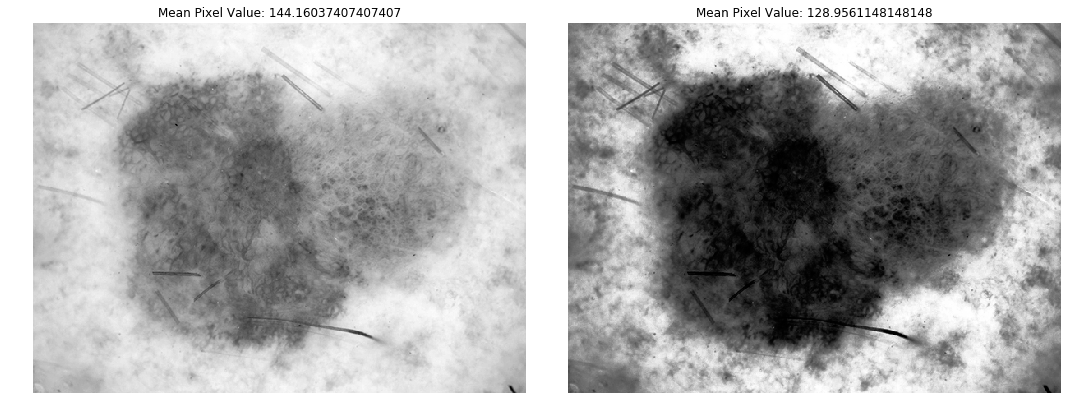

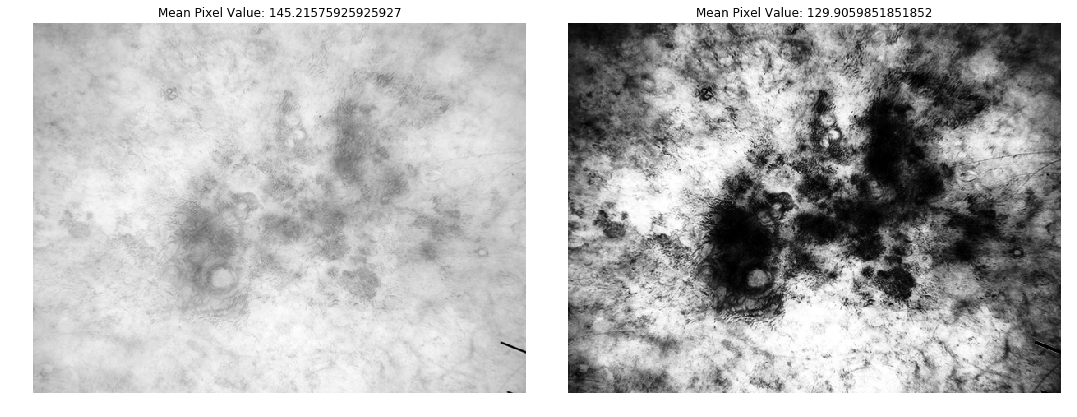

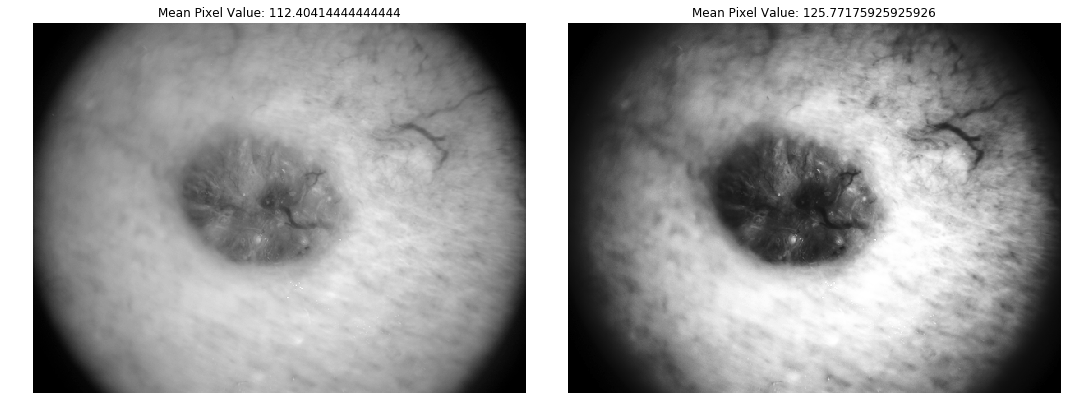

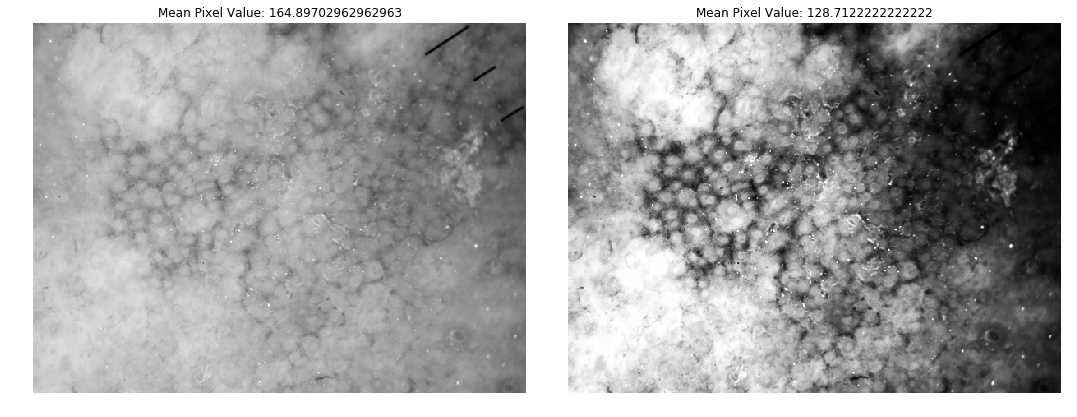

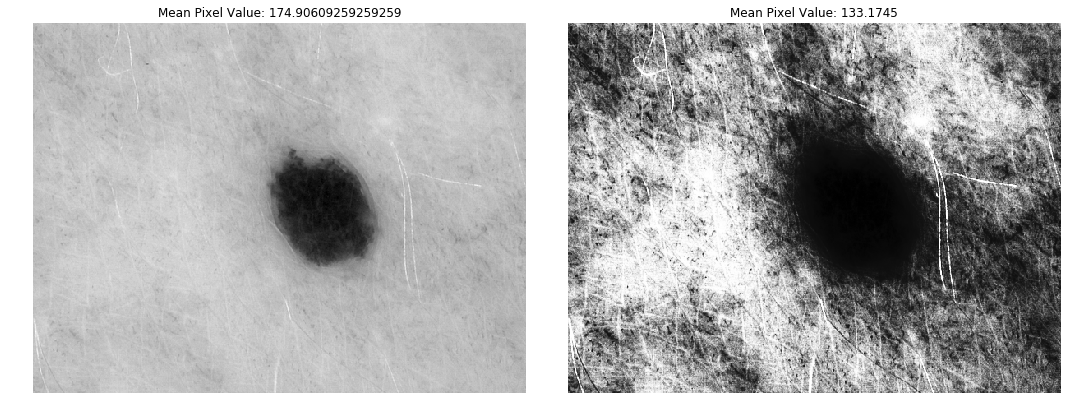

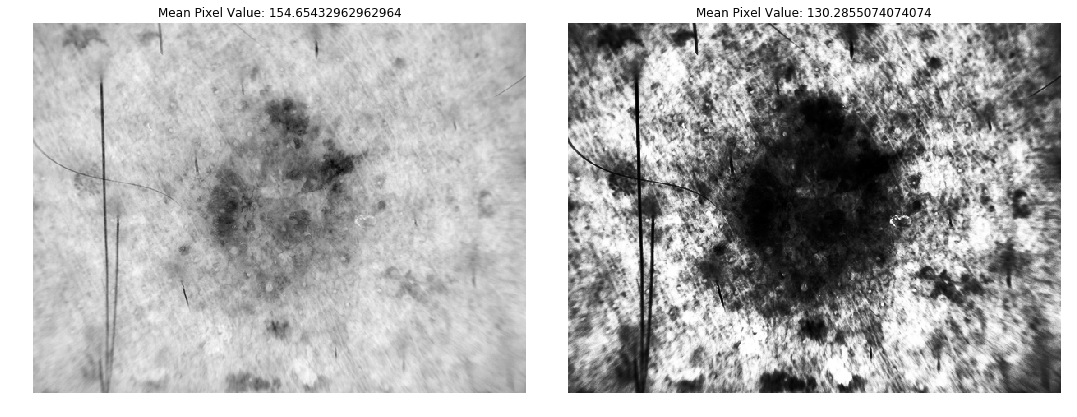

In [10]:
# apply preprocesing and display both side by side for each class
num_images = 2
for _class in classes:
    # plotting
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 15), squeeze=False)
    fig.tight_layout()
    row = _class.sample(n=1)
    _id = row["image_id"].to_string(index=False).strip()
    image = cv2.imread("../ham10000/{}.jpg".format(_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_preprocessed = preprocess(image)
    for l in range(1):
        for m, img in enumerate([image, image_preprocessed]):
            axes[l][m].imshow(img, cmap="gray")
            axes[l][m].axis("off")
            axes[l][m].set_title("Mean Pixel Value: {}".format(np.mean(img)))

## Seperate Images into Respective Folders

In [29]:
import shutil
# seperate images to each directory 
os.mkdir("ham_labled")
# each class
for _class in classes:
    # make a subdirectory
    os.mkdir("ham_labled/{}".format(_class.name))
    for i, row in _class.iterrows():
        image_id = row["image_id"]
        #.to_string(index=False).strip()
        shutil.move(
            src="../ham10000/{}.jpg".format(image_id), 
            dst="ham_labled/{}/".format(_class.name)
        )
    print("Moving complete for class {}...".format(_class.name))

Moving complete for class nv...
Moving complete for class mel...
Moving complete for class bkl...
Moving complete for class bcc...
Moving complete for class akiec...
Moving complete for class vasc...
Moving complete for class df...


## Image Augumentation

Before we can start passing above images through a CNN feature extractor, we will augument images to address class imbalance problem and set a threshold of 5000 images per class.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
_generator = ImageDataGenerator(
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    shear_range=0.01,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=9.0
)

In [55]:
classes = ["test_class", "test_class_2", "test_class_3"]

_auguments = _generator.flow_from_directory(
    directory="aug_test/",
    color_mode="rgb",
    batch_size=2,
    target_size=(450, 600),
    save_prefix="augumented",
    save_to_dir="aug_test/"
)
classess = _auguments.class_indices
print(classess)

Found 6 images belonging to 4 classes.
{'.ipynb_checkpoints': 0, 'test_class': 1, 'test_class_2': 2, 'test_class_3': 3}


## Feature Extraction and CNN Setup

The class HDF5IO has the utilities to read/write extracted features from images

In [17]:
import os
import h5py


class HDF5IO:

    def __init__(self, dims, output_path, data_key="images", buf_size=1000):
        if os.path.exists(output_path):
            raise ValueError(
                "The path already exists and cannot be overwritten",
                output_path
            )
        self.db = h5py.File(output_path, "w")
        self.data = self.db.create_dataset(
            data_key,
            dims,
            dtype="float"
        )
        self.labels = self.db.create_dataset(
            "labels",
            (dims[0],),
            dtype="int"
        )
        self.buf_size = buf_size
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        """
        Adds the rows and labels to the buffer
        :param rows:
        :param labels:
        :return:
        """
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.buf_size:
            self.flush()

    def flush(self):
        """
        Write the buffers to disk then reset the buffer
        :return:
        """
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def store_class_labels(self, class_labels):
        """
        create a dataset to store the actual class label names,
        then store the class labels
        :return:
        """
        dt = h5py.special_dtype(vlen=str)
        label_set = self.db.create_dataset(
            "label_names",
            (len(class_labels),),
            dtype=dt
        )
        label_set[:] = class_labels

    def close(self):
        """
        Closes the dataset
        :return:
        """
        if len(self.buffer["data"]) > 0:
            self.flush()
        # close the dataset
        self.db.close()


In [ ]:
from keras.applications import VGG16
from keras.applications import imagenet_utils
from sklearn.preprocessing import LabelEncoder